<IPython.core.display.Javascript object>


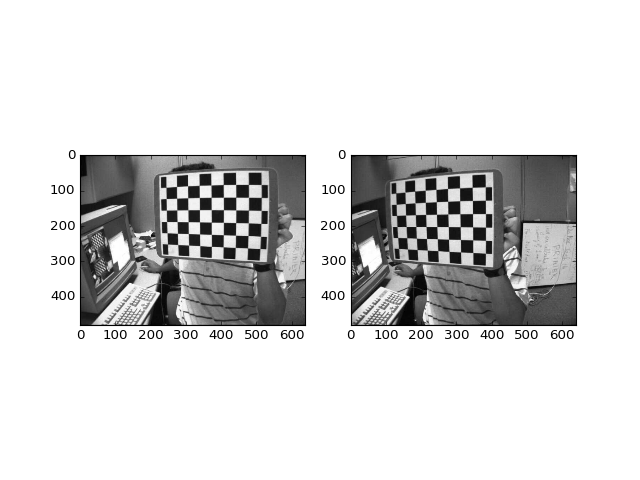

In [102]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import numpy as np
import cv2

image_left = cv2.imread('left01.jpg')
image_right = cv2.imread('right01.jpg')

plt.subplot(121)
plt.imshow(image_left[:,:])
plt.subplot(122)
plt.imshow(image_right[:,:])
plt.show()


In [45]:
    print(image_left.shape)
    print(image_right.shape)
#     print(type(image_left))
#     print(image_left[0:2,0:6])
 

(480, 640, 3)
(480, 640, 3)


##  Finding Checkerboard Corners
To calibrate the camera, we need to estabilish correspondences a set of correspondences between 3D world points and 2D image points.Hence, we need to find the corners of the checkerboard in each image and relate them to the actual 3D coordinates in the arbitrary coordinated system associated to the checkerboard.

In [23]:
ret, corners = cv2.findChessboardCorners(image_left, (7,6))
print(corners.shape)
print(corners[:2,:])
#print(corners[0])


(42, 1, 2)
[[[475.46497 264.59277]]

 [[440.46597 263.34772]]]


In [25]:
corners=corners.reshape(-1,2)
print corners.shape
print corners[:2,:]

(42, 2)
[[475.46497 264.59277]
 [440.46597 263.34772]]


### We can now print the corners using the function drawChessboardCorners. Since this function would overwrite the content of img1, a good idea would be to create a copy for visualization only:


<IPython.core.display.Javascript object>


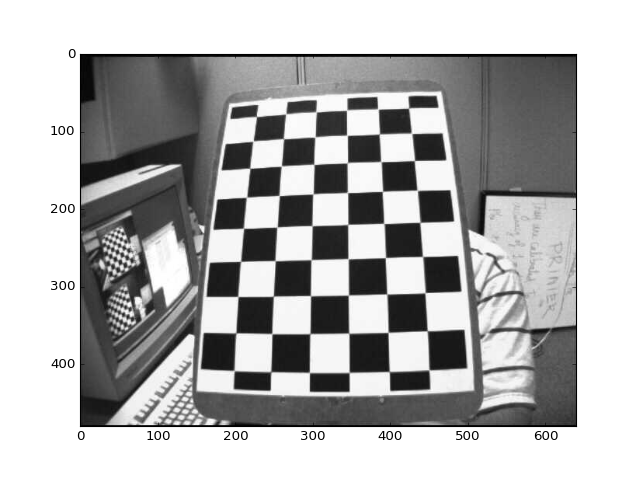

nothing


In [47]:
%matplotlib nbagg
im_left_vis=image_left.copy()
cv2.drawChessboardCorners(im_left_vis, (7,6), corners, ret)
plt.imshow(im_left_vis)
plt.show()
print('nothing')

## Calibration
### Now we need to specify a 3D coordinate system for each of the 42 detected points. We will choose the following coordinate system:


#### To create such array, we first create a meshgrid which will give us all combinations of X-Y coordinates:


In [51]:
x,y=np.meshgrid(range(7),range(6))
print "x:\n",x
print "y:\n",y

x:
[[0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]
 [0 1 2 3 4 5 6]]
y:
[[0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5]]


##  We now have our correspondences between 3D and 2D points, i.e., each row of world_points corresponds to a row of corners. We can show some of these correspondences:


In [68]:
world_points=np.hstack((x.reshape(42,1),y.reshape(42,1),np.zeros((42,1)))).astype(np.float32)
#print world_points

In [54]:
print corners[0],'->',world_points[0]
print corners[35],'->',world_points[35]


[475.46497 264.59277] -> [0. 0. 0.]
[477.623   86.3797] -> [0. 5. 0.]


## We could already calibrate our camera using a single image, but this would likely result in an imprecise calibration. Therefore, we need to load all images, finding corners and creating two lists of corresponding 3D and 2D coordinates.


In [55]:


from glob import glob

_3d_points=[]
_2d_points=[]

img_paths=glob('data/*.jpg') #get paths of all images
for path in img_paths:
    im=cv2.imread(path)
    ret, corners = cv2.findChessboardCorners(im, (7,6))

    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) #append current 2D points
        _3d_points.append(world_points) #3D points are always the same


## To calibrate the camera, we can use the cv2.calibrateCamera function:
#### Note that we need to specify the dimensions of each image in the width×height

format. Since the shape attribute contains the number of rows and columns, the two numbers need to be inverted (rows=height, columns=width), i.e., using (im1.shape[1],im1.shape[0]) rather than (im1.shape[0],im1.shape[1]).

According to the documentation, The function returns the following values:

    ret: the mean reprojection error (it should be as close to zero as possible);
    mtx: the matrix of intrisic parameters;
    dist: the distortion parameters;
    rvecs: the rotation vectors (one per image);
    tvecs: the translation vectors (one per image).



In [140]:
    ret, int_mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]),None,None)
    print "Ret:",ret
    print "Mtx:",int_mtx," ----------------------------------> [",int_mtx.shape,"]"
#     print "Dist:",dist," ----------> [",dist.shape,"]"
#     print "rvecs:",rvecs," --------------------------------------------------------> [",rvecs[0].shape,"]"
#     print "tvecs:",tvecs," -------------------------------------------------------> [",tvecs[0].shape,"]"



Ret: 0.516606677512
Mtx: [[532.44806049   0.         332.88041832]
 [  0.         532.94912918 239.68293164]
 [  0.           0.           1.        ]]  ----------------------------------> [ (3, 3) ]


### Image Rectification
#### While cameras are designed to adhere to the pinhole camera model, in practice, real camaras tend to deviate from it. The effect of such deviation is that some parts of the image tend to look "distorted", e.g., lines which we know should be straight, do not look so straing. For instance, let's visualize image left12.jpg:


<IPython.core.display.Javascript object>


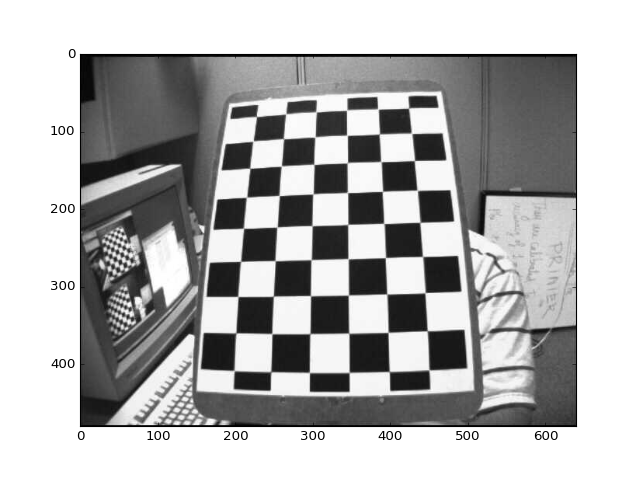

In [141]:
%matplotlib nbagg
plt.imshow(cv2.imread('data/left12.jpg')[...,::-1])
plt.show()


<IPython.core.display.Javascript object>


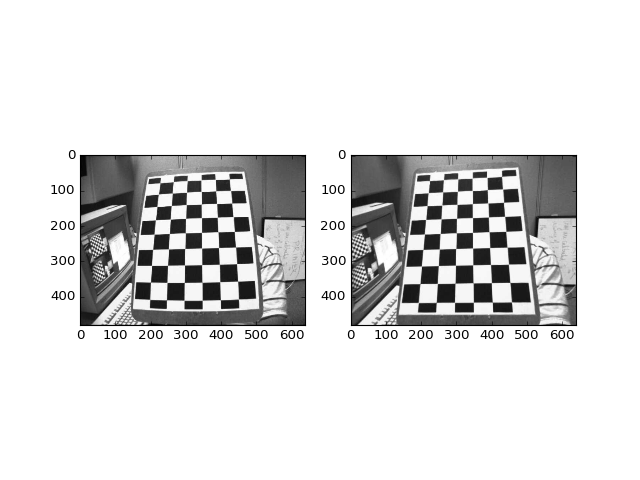

In [142]:
%matplotlib nbagg
im=cv2.imread('data/left12.jpg')[:,:]
im_undistorted=cv2.undistort(im, int_mtx, dist)
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(im_undistorted)
plt.show()


## Drawing 3D points on the scene
### Now that the camera is calibrated for both the extrinsic and intrinsic parameters, we can project points from the 3D world to the 2D image plane. This can be used, for instance, to implement "augmented reality" algorithms which draw 3D objects on the image. Let's see how to draw a cube on the checkerboard. First, define the 8 corners of a cube of side 3:


In [155]:
_3d_corners = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                           [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]])

img=cv2.imread('left07.jpg') #load the correct image
image_index=6
cube_corners_2d,_ = cv2.projectPoints(_3d_corners,rvecs[image_index],tvecs[6],int_mtx,dist)
#the underscore allows to discard the second output parameter (see doc)
#I need to point to the right rotation and translation matrix of each image.

print cube_corners_2d.shape #the output consists in 8 2-dimensional points
#print(img_paths[image_index])
red=(0,0,255) #red (in BGR)
blue=(255,0,0) #blue (in BGR)
green=(0,255,0) #green (in BGR)
line_width=5


(8, 1, 2)


## We can project points to the 2D image plane using the function cv2.projectPoints. Since we need to project them on a specific image, we first need to choose one of the considered images:

### We can now plot lines on the 3D image using the cv2.line function:


<IPython.core.display.Javascript object>


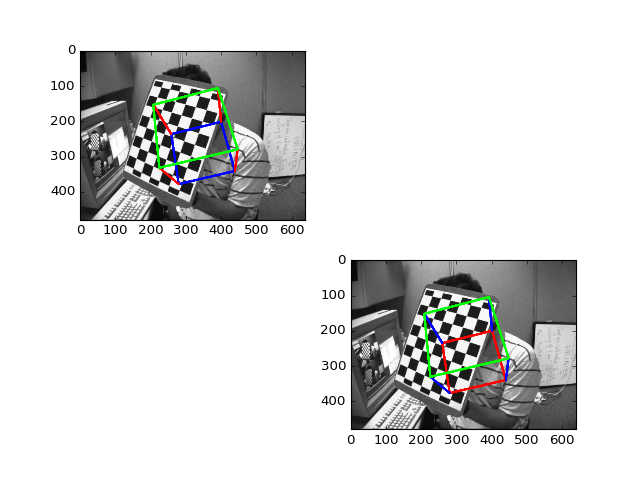

In [158]:
#first draw the base in red
cv2.line(img, tuple(cube_corners_2d[0][0]), tuple(cube_corners_2d[1][0]),red,line_width)
cv2.line(img, tuple(cube_corners_2d[1][0]), tuple(cube_corners_2d[2][0]),red,line_width)
cv2.line(img, tuple(cube_corners_2d[2][0]), tuple(cube_corners_2d[3][0]),red,line_width)
cv2.line(img, tuple(cube_corners_2d[3][0]), tuple(cube_corners_2d[0][0]),red,line_width)

#now draw the pillars
cv2.line(img, tuple(cube_corners_2d[0][0]), tuple(cube_corners_2d[4][0]),blue,line_width)
cv2.line(img, tuple(cube_corners_2d[1][0]), tuple(cube_corners_2d[5][0]),blue,line_width)
cv2.line(img, tuple(cube_corners_2d[2][0]), tuple(cube_corners_2d[6][0]),blue,line_width)
cv2.line(img, tuple(cube_corners_2d[3][0]), tuple(cube_corners_2d[7][0]),blue,line_width)

#finally draw the top
cv2.line(img, tuple(cube_corners_2d[4][0]), tuple(cube_corners_2d[5][0]),green,line_width)
cv2.line(img, tuple(cube_corners_2d[5][0]), tuple(cube_corners_2d[6][0]),green,line_width)
cv2.line(img, tuple(cube_corners_2d[6][0]), tuple(cube_corners_2d[7][0]),green,line_width)
cv2.line(img, tuple(cube_corners_2d[7][0]), tuple(cube_corners_2d[4][0]),green,line_width)

#cv2.line(img, tuple(start_point), tuple(end_point),(0,0,255),3) #we set the color to red (in BGR) and line width to 3
plt.subplot(221)
plt.imshow(img[:,:])
plt.subplot(224)
plt.imshow(img[...,::-1])
plt.show()
